# Linear Logistic Regression in NumPy

Fast logistic regression in NumPy with Conjugate Gradients from the SciPy optimize module.

In [1]:
import numpy as np
import scipy.optimize as spopt

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

Some basic numerical functions, `cap_zero` takes values very close or equal to zero and makes them "tiny" non-zero values.  `softmax` computes the softmax along the last axis of a multi-axis array and `log_softmax` compute the natural log of the softmax along the last axis, in a way that is slightly faster and more numerically stable than computing the direct log of `softmax`.

In [2]:
def cap_zero(x, value=None):
    '''Return a copy of `x` where all values are capped at `value`,
    i.e., no values in the array are less than `value`.  If `value`
    is `None` (default) then the `np.finfo` `tiny` value is used
    for the `dtype` of `x`.
    '''
    if value is None:
        value = np.finfo(x.dtype).tiny
    x = x.copy()
    x[x < value] = value
    return x

def softmax(x):
    '''Compute the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))
    terms = cap_zero(np.exp(x - mx))
    denom = np.sum(terms, axis=-1)[..., None]
    return terms / denom

def log_softmax(x):
    '''Compute the natural log of the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))                                                                   
    xmx = x - mx                                                                                    

    terms = cap_zero(np.exp(xmx))
    denom = np.sum(terms, axis=-1)[..., None]
    log_denom = np.log(cap_zero(denom))
                                                                                                             
    return xmx - log_denom

And now for the logistic regression implementation...

In [3]:
class LogisticRegression:
    '''Linear Logistic Regression.
    
    Inputs:
        x: np.array((..., ndim))
            The input features over which to perform a prediction.
            
    Outputs:
        logits: np.array((..., ncls))
            Predicted logit indicators for each class.  Higher values
            indicate a more confident prediction.  For predicted
            probabilities in (0,1), see the `.probs` method.
            For integer predicted class labels, see the `.labels` method.
    '''
    def __init__(self, ndim, ncls):
        '''Construct a new Linear Logistic Regression classifier.
        
        Args:
            ndim: int
                The number of input dimensions / features.
            ncls: int
                The number of classes in a prediction.
        '''
        self.ndim, self.ncls = ndim, ncls

        weight_scale = np.sqrt(3.0) / ndim
        self.weights = np.random.uniform(
            -weight_scale, weight_scale,
            size=(self.ndim+1, self.ncls))
        
    @property
    def parameters(self):
        '''Return a single flat NumPy array containing all of the
        parameters for this model.  Used for optimization with
        `scipy.optimize`.
        '''
        return self.weights.ravel()
        
    def __call__(self, x):
        '''Return predicted logits.'''
        assert x.ndim >= 2
        return x @ self.weights[:-1] + self.weights[-1]
    
    def probs(self, x):
        '''Return the predicted class membership probabilities.'''
        return softmax(self(x))
    
    def labels(self, x):
        '''Return the predicted class labels as integers.'''
        return np.argmax(self(x), axis=-1)
    
    def loss(self, x, g):
        '''Return the log loss, i.e., cross-entropy loss.'''
        likes = log_softmax(self(x))
        
        # pointwise multiplication of log likelihoods times target indicator
        # variables can be computed by simply selecting along the last axis
        likes_g = np.take_along_axis(likes, g[..., None], axis=-1)
        
        return -np.mean(likes_g)
    
    def grad(self, x, g):
        '''Return the gradient matrix using cross-entropy loss.
        This should be flattened for use with `scipy.optimize`.'''
        probs = softmax(self(x))

        delta = probs.reshape((-1, probs.shape[-1]))
        delta[range(delta.shape[0]), g.flat] -= 1.0
        
        x1 = np.concatenate((x, np.ones_like(x[..., 0])[..., None]), axis=-1)
        grad = x1.T.reshape((x1.shape[-1], -1)) @ delta
        
        return grad
    
    def train(self, x, g, precision=1.0e-6, method='cg', **options):
        '''Train this logistic regression model using `scipy.optimize.minimize`.
        The model is trained in place.
        
        Args:
            x: np.array(..., ndim)
                The training input data.
            g: np.array(...)
                Integer target class labels.
            precision: float
                The precision after which training will terminate.
            method: str
                The training method used by `scipy.optimize`.
                Defaults to `cg` conjugate gradients.
            **options:
                Additonal arguments to pass to `scipy.optimize.minimize`.
                
        Returns:
            dict
                A dictionary of result information returned by the
                `scipy.optimize.minimize` function.
        '''
        def loss_func(parameters):
            '''Set parameters on self and computes the log loss.'''
            self.parameters[...] = parameters
            return self.loss(x, g)
        
        def grad_func(parameters):
            '''Set parameters on self and compute the flattened gradient.'''
            self.parameters[...] = parameters
            return self.grad(x, g).ravel()
        
        # deligate minimization to scipy
        return spopt.minimize(
            fun=loss_func, method=method, x0=self.parameters,
            tol=precision, jac=grad_func, options=options)

A simple test with multi-axis arrays.  The last axis is for features, any earlier axes are additional observations, e.g., `number_of_sentences` x `number_of_words` x `word_embedding_size`.

In [4]:
inputs = np.random.random((4, 10, 32))
targets = np.array(inputs.sum(-1) < 0.5, dtype=np.int)

lr_model = LogisticRegression(32, 2)
opt_result = lr_model.train(inputs, targets)
print(opt_result)

logits = lr_model(inputs)
probs = lr_model.probs(inputs)
labels = lr_model.labels(inputs)
loss = lr_model.loss(inputs, targets)
grad = lr_model.grad(inputs, targets)

print('logits:', logits.shape)
print('probs:', probs.shape)
print('labels:', labels.shape)
print('loss:', loss)

     fun: 2.3395612458450523e-08
     jac: array([-5.0341e-07,  5.0341e-07, -3.8969e-07,  3.8969e-07, -4.1527e-07,
        4.1527e-07, -4.8991e-07,  4.8991e-07, -5.8589e-07,  5.8589e-07,
       -5.4501e-07,  5.4501e-07, -5.5094e-07,  5.5094e-07, -4.3892e-07,
        4.3892e-07, -3.9386e-07,  3.9386e-07, -3.9843e-07,  3.9843e-07,
       -4.2482e-07,  4.2482e-07, -4.0112e-07,  4.0112e-07, -3.4595e-07,
        3.4595e-07, -5.0052e-07,  5.0052e-07, -5.3817e-07,  5.3817e-07,
       -4.5315e-07,  4.5315e-07, -5.8169e-07,  5.8169e-07, -4.6521e-07,
        4.6521e-07, -5.6118e-07,  5.6118e-07, -4.4612e-07,  4.4612e-07,
       -4.6910e-07,  4.6910e-07, -4.3368e-07,  4.3368e-07, -5.0750e-07,
        5.0750e-07, -4.5787e-07,  4.5787e-07, -5.5759e-07,  5.5759e-07,
       -4.7507e-07,  4.7507e-07, -4.2128e-07,  4.2128e-07, -4.8547e-07,
        4.8547e-07, -4.5860e-07,  4.5860e-07, -5.1882e-07,  5.1882e-07,
       -3.0909e-07,  3.0909e-07, -4.5792e-07,  4.5792e-07, -9.3582e-07,
        9.3582e-07])


Conjugate gradients documentation below.  CG should be able to solve in number of inputs iterations (plus a few for numerical precision).  Note that there may be multiple function and gradient evaluations for each iteration, each iteration corresponds to a search direction but still have to optimize along each direction.

In [5]:
#spopt.fmin_cg?

A 1D example with three classes, shows that it works!!

     fun: 0.08211419781165827
     jac: array([ 0.3815, -0.6749,  0.2934, -0.4143, -0.2516,  0.6658])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 40
     nit: 10
    njev: 40
  status: 1
 success: False
       x: array([-10.4714,   1.6296,   9.8833,  -3.122 ,   2.7204,  -1.926 ])
c1:
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
c2:
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1]
c3:
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


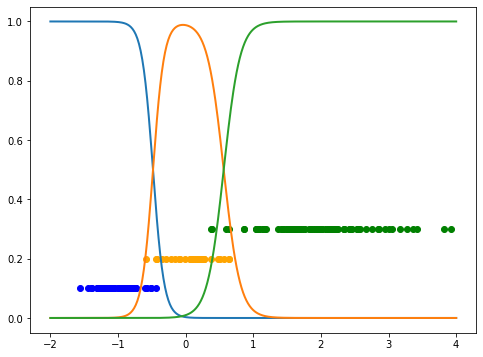

In [6]:
c1 = np.random.normal(loc=-1.0, scale=0.3, size=(60, 1))
c2 = np.random.normal(loc=0.0, scale=0.3, size=(30, 1))
c3 = np.random.normal(loc=2.0, scale=0.7, size=(90, 1))
inputs = np.concatenate((c1, c2, c3), axis=0)
targets = np.array([0,]*c1.size + [1,]*c2.size + [2,]*c3.size)

model = LogisticRegression(1, 3)
opt_result = model.train(inputs, targets, method='cg', maxiter=10)
print(opt_result)
                                                                                                    
c1_probs = model.probs(c1)                                                                       
c2_probs = model.probs(c2)                                                                       
c3_probs = model.probs(c3)                                                                       
                                                                                                    
print("c1:")                                                                                    
print(model.labels(c1))                                                                          
print("c2:")                                                                                    
print(model.labels(c2))                                                                          
print("c3:")                                                                                    
print(model.labels(c3))                                                                          
                                                                                                    
x = np.linspace(-2.0, 4.0, 500)[:, None]
x_probs = model.probs(x)                                                                         
                                                                                                    
plt.plot(x, x_probs, linewidth=2)
plt.scatter(c1, np.zeros_like(c1) + 0.1, color='blue');
plt.scatter(c2, np.zeros_like(c2) + 0.2, color='orange');
plt.scatter(c3, np.zeros_like(c3) + 0.3, color='green');

In [7]:
# covariance matrix for each training class
cov = [[1, -0.8],
       [-0.8, 1]]

# red data
red = np.random.multivariate_normal((-1, -1), cov, 500)

# green data
green = np.random.multivariate_normal((0, 0), cov, 300)

# blue data
blue = np.random.multivariate_normal((1, 1), cov, 400)

inputs = np.vstack((red, green, blue))
targets = np.array(([0,]*red.shape[0] + [1,]*green.shape[0] + [2,]*blue.shape[0]))

# min and max training values                                                                   
mn = np.min(inputs, axis=0)
mx = np.max(inputs, axis=0)

# train model
model2 = LogisticRegression(2, 3)
opt_result = model2.train(inputs, targets)

print('optimization result:')
print(opt_result)

# find class labels
red_labels = model2.labels(red)
green_labels = model2.labels(green)                                                                 
blue_labels = model2.labels(blue)                                                                   
                                                                                                    
print("\nred labels:")
print(red_labels)                                                                                 
print("\ngreen labels:")
print(green_labels)                                                                               
print("\nblue labels:")
print(blue_labels)

optimization result:
     fun: 0.16510982066688448
     jac: array([ 2.0249e-05, -1.6653e-05, -3.5957e-06, -6.1641e-06,  2.3774e-05,
       -1.7610e-05, -5.2430e-06,  1.0539e-05, -5.2963e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 439
     nit: 65
    njev: 427
  status: 2
 success: False
       x: array([-5.2588, -0.2744,  5.766 , -5.1847, -0.3254,  5.8365, -1.365 ,
        2.9847, -2.2814])

red labels:
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

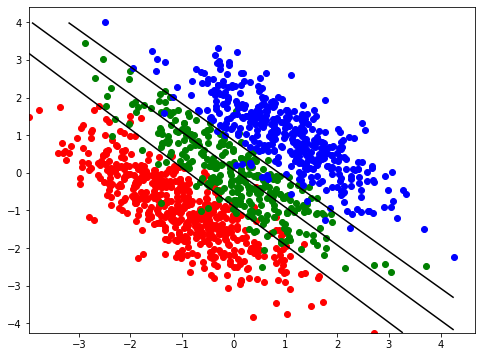

In [8]:
# first figure shows training data and class intersections
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# training data
ax.scatter(red[:,0],   red[:,1],   color='red')
ax.scatter(green[:,0], green[:,1], color='green')
ax.scatter(blue[:,0],  blue[:,1],  color='blue')

# generate grid over training data
sw = 0.02
sx = np.arange(mn[0], mx[0], sw)
sy = np.arange(mn[1], mx[1], sw)
x, y = np.meshgrid(sx, sy, copy=False)

# get probability densities and labels for values in grid
z = np.vstack((x.reshape((-1,)), y.reshape((-1,)))).T
probs = model2.probs(z)

# red, green, blue and max probability densities
redp = np.reshape(probs[:,0,None], x.shape)
greenp = np.reshape(probs[:,1,None], x.shape)
bluep = np.reshape(probs[:,2,None], x.shape)
maxp = np.reshape(np.max(probs, axis=1), x.shape)

# class intersections
diff_rg = redp   - greenp
diff_rb = redp   - bluep
diff_gb = greenp - bluep
ax.contour(x, y, diff_rg, colors="black", levels=(0,));
ax.contour(x, y, diff_rb, colors="black", levels=(0,));
ax.contour(x, y, diff_gb, colors="black", levels=(0,));

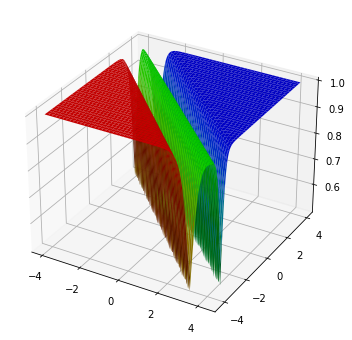

In [9]:
# second figure shows 3d plots of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# straight class colors for suface plots
color = np.reshape((redp, greenp, bluep), (3, x.shape[0], x.shape[1]))
color = color.swapaxes(1, 2).T

# flip colors to fade to white
zro = np.zeros_like(x)
color_flip = np.ones((3, x.shape[0], x.shape[1]))
color_flip -= (
    np.array((zro, redp, redp)) +
    np.array((greenp, zro, greenp)) +
    np.array((bluep, bluep, zro))
)
color_flip -= np.min(color_flip)
color_flip /= np.max(color_flip)
color_flip = color_flip.swapaxes(1, 2).T

# probability density surface
surf = ax.plot_surface(x, y, maxp, facecolors=color_flip,
                       linewidth=0.02, shade=True)

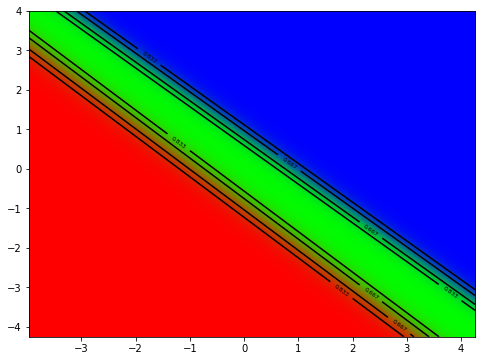

In [10]:
# third figure shows contours and color image of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ax.pcolor(x, y, pMax)
ax.imshow(color_flip, origin='lower',
          extent=(mn[0], mx[0], mn[1], mx[1]), aspect='auto')

# contours
nlevel = 4
cs = ax.contour(x, y, maxp, colors='black',
                levels=np.linspace(np.min(maxp), np.max(maxp), nlevel));
cs.clabel(fontsize=6);

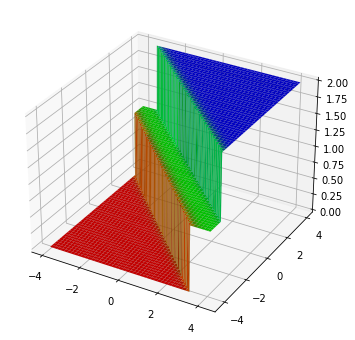

In [11]:
# fourth figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

labels = model2.labels(z)
lmax = np.reshape(labels, x.shape)

surf = ax.plot_surface(x, y, lmax, facecolors=color_flip, linewidth=0.02)
surf.set_edgecolor('black')

Just some tinkering around with NumPy indexing... I'll delete this once I'm sure it's how I want it above.

In [12]:
a = np.random.random((10, 12))
b = np.random.random(10*12)

a.flat[...] = b

a, b

(array([[0.5112, 0.6789, 0.3861, 0.4311, 0.843 , 0.9086, 0.8577, 0.3496,
         0.5155, 0.4966, 0.3685, 0.9809],
        [0.9686, 0.402 , 0.9554, 0.3774, 0.8171, 0.0713, 0.5981, 0.4709,
         0.009 , 0.5719, 0.5797, 0.751 ],
        [0.5127, 0.0488, 0.0329, 0.7036, 0.8793, 0.5441, 0.0238, 0.0857,
         0.8682, 0.2196, 0.136 , 0.7945],
        [0.322 , 0.1827, 0.176 , 0.0747, 0.7152, 0.5884, 0.0116, 0.914 ,
         0.8594, 0.8251, 0.4834, 0.6397],
        [0.1908, 0.4363, 0.9171, 0.2008, 0.4708, 0.4983, 0.8935, 0.822 ,
         0.8378, 0.0339, 0.3027, 0.4566],
        [0.8108, 0.3406, 0.5562, 0.4606, 0.3505, 0.5704, 0.8747, 0.7282,
         0.5667, 0.3197, 0.9375, 0.1013],
        [0.2193, 0.7403, 0.3707, 0.1186, 0.9399, 0.3455, 0.437 , 0.7046,
         0.0142, 0.8702, 0.8655, 0.2217],
        [0.572 , 0.5807, 0.436 , 0.0743, 0.1965, 0.9173, 0.6315, 0.9543,
         0.4005, 0.1399, 0.1763, 0.5442],
        [0.1992, 0.8001, 0.4391, 0.9772, 0.3663, 0.0035, 0.6869, 0.402 ,
       

In [13]:
a = np.random.random((2, 4, 3))
g = np.array([0, 0, 2, 1])
a.shape, a[..., range(a.shape[1]), g].shape
a, a[..., range(a.shape[-2]), g]

(array([[[0.4265, 0.1582, 0.0485],
         [0.8022, 0.0904, 0.6464],
         [0.5393, 0.1438, 0.5879],
         [0.6828, 0.6221, 0.5168]],
 
        [[0.4256, 0.0955, 0.9252],
         [0.9918, 0.5073, 0.4666],
         [0.2171, 0.5721, 0.0402],
         [0.5282, 0.2347, 0.0757]]]),
 array([[0.4265, 0.8022, 0.5879, 0.6221],
        [0.4256, 0.9918, 0.0402, 0.2347]]))

In [14]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])
print(g, g.shape)
print(a, a.shape)
print(a[range(a.shape[0]), g], a[range(a.shape[0]), g].shape)

[0 0 2 1] (4,)
[[0.4264 0.304  0.2816]
 [0.0165 0.5295 0.5922]
 [0.5523 0.8361 0.2241]
 [0.5384 0.0058 0.5658]] (4, 3)
[0.4264 0.0165 0.2241 0.0058] (4,)


In [15]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])
rows, cols = np.indices(a.shape[:-1])
a, a[rows, cols, g]

(array([[[0.9884, 0.2194, 0.9595],
         [0.4212, 0.2017, 0.2834],
         [0.7035, 0.1302, 0.7467],
         [0.0279, 0.0179, 0.9443]],
 
        [[0.7725, 0.2803, 0.8698],
         [0.1421, 0.3415, 0.4607],
         [0.9117, 0.1065, 0.6939],
         [0.6248, 0.3319, 0.8554]]]),
 array([[0.9884, 0.4212, 0.7467, 0.0179],
        [0.7725, 0.1421, 0.1065, 0.8554]]))

In [16]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])[:, None]
a, np.take_along_axis(a, g, axis=-1)

(array([[0.6307, 0.384 , 0.4284],
        [0.3624, 0.9566, 0.4721],
        [0.2585, 0.0831, 0.2329],
        [0.7067, 0.6058, 0.5771]]),
 array([[0.6307],
        [0.3624],
        [0.2329],
        [0.6058]]))

In [17]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])[..., None]
a, np.take_along_axis(a, g, axis=-1)

(array([[[0.8612, 0.4626, 0.9317],
         [0.4764, 0.2568, 0.5881],
         [0.9414, 0.6646, 0.1579],
         [0.6323, 0.8809, 0.6088]],
 
        [[0.0112, 0.0788, 0.3001],
         [0.4842, 0.401 , 0.2096],
         [0.6653, 0.398 , 0.0647],
         [0.0634, 0.544 , 0.9548]]]),
 array([[[0.8612],
         [0.4764],
         [0.1579],
         [0.8809]],
 
        [[0.0112],
         [0.4842],
         [0.398 ],
         [0.9548]]]))

In [18]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])

a, a.reshape((-1, a.shape[-1]))[range(2*4), g.flat].reshape(g.shape)

(array([[[0.9172, 0.5454, 0.072 ],
         [0.1614, 0.0849, 0.1528],
         [0.145 , 0.381 , 0.6697],
         [0.4716, 0.1301, 0.565 ]],
 
        [[0.2033, 0.3473, 0.8656],
         [0.879 , 0.3086, 0.4138],
         [0.261 , 0.1587, 0.1869],
         [0.2244, 0.2832, 0.5476]]]),
 array([[0.9172, 0.1614, 0.6697, 0.1301],
        [0.2033, 0.879 , 0.1587, 0.5476]]))

In [19]:
a = np.random.random((2, 4))
g = np.array([0, 1])

a, np.take_along_axis(a, g[:, None], axis=-1)
a, a[range(a.shape[0]), g]

(array([[0.4536, 0.2868, 0.8058, 0.867 ],
        [0.8193, 0.6088, 0.7858, 0.3509]]),
 array([0.4536, 0.6088]))

In [20]:
(3,) * 4

(3, 3, 3, 3)